<a href="https://colab.research.google.com/github/karthikeyansura/store-sales-time-series-modeling/blob/data-preprocessing-BhanuHarshaY/store_sales_time_series_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Store Sales - Time Series Forecasting**

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
import os
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Feature Selection
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold, RFE
from sklearn.ensemble import RandomForestRegressor

# For Autoencoder (embedding-based feature selection)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries imported successfully!")

All libraries imported successfully!


#### **To run this notebook, you need your personal Kaggle API credentials. Follow these steps to generate them:**

1.   Log into **[Kaggle.com](https://www.kaggle.com)**.
2.   Click your profile picture in the top-right corner and select **Settings**.
3. **Username:** Your username is listed at the top of the Account tab.
4. Scroll down to the **"Legacy API Credentials"** section and click on **"Create Legacy API Key"**
5. A file named `kaggle.json` will download to your computer. Open that and copy the random string found inside the `"key": "..."` section and Replace `"ENTER_YOUR_KEY_HERE"` and replace `"ENTER_YOUR_USERNAME_HERE"` with your actual username.



In [2]:
import os

# LOADING THE DATASET

# Kaggle API configuration
os.environ['KAGGLE_USERNAME'] = "ENTER_YOUR_USERNAME_HERE"
os.environ['KAGGLE_KEY'] = "ENTER_YOUR_KEY_HERE"

# setup paths
COMP_NAME = 'store-sales-time-series-forecasting'
BASE_PATH = f'/content/{COMP_NAME}/'

# download files
if not os.path.exists(BASE_PATH):
    print(f"Downloading {COMP_NAME}...")
    !mkdir -p {BASE_PATH}

    !mkdir -p ~/.kaggle
    with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
        f.write('{"username":"' + os.environ['KAGGLE_USERNAME'] + '","key":"' + os.environ['KAGGLE_KEY'] + '"}')
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle competitions download -c {COMP_NAME} -p {BASE_PATH}
    !unzip -q {BASE_PATH}{COMP_NAME}.zip -d {BASE_PATH}
    !rm {BASE_PATH}{COMP_NAME}.zip
    print("Download complete.")
else:
    print("Data already downloaded.")

# load dataset into df
train = pd.read_csv(BASE_PATH + 'train.csv', parse_dates=['date'])
test = pd.read_csv(BASE_PATH + 'test.csv', parse_dates=['date'])
stores = pd.read_csv(BASE_PATH + 'stores.csv')
oil = pd.read_csv(BASE_PATH + 'oil.csv', parse_dates=['date'])
holidays = pd.read_csv(BASE_PATH + 'holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv(BASE_PATH + 'transactions.csv', parse_dates=['date'])

print(f"Train shape: {train.shape}")
print("All datasets loaded successfully!")

  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 1.64GB/s]
Download complete.
Train shape: (3000888, 6)
All datasets loaded successfully!


**Rationale:** We selected this method to load the dataset because it allows the entire team to execute the code easily without requiring manual directory management on local machines. Rather than relying on individual file downloads or identical Google Drive configurations, this script automatically retrieves the data directly from Kaggle into the notebook environment at runtime.

Dataset Overview
Total number of samples in train dataset: 3000888
Total number of samples in test dataset: 28512
Total number of samples: 3029400
Total number of features: 5 features + 1 target variable (sales)

Supplementary Datasets Overview
Stores dataset shape: (54, 5)
Oil dataset shape: (1218, 2)
Holidays dataset shape: (350, 6)
Transactions dataset shape: (83488, 3)
Stores metadata: 54 stores with 5 features
Oil prices: 1218 daily records
Holidays: 350 holidays
Transactions: 83488 records

Train Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None

First 5 

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0



Data Distribution of target class Sales:


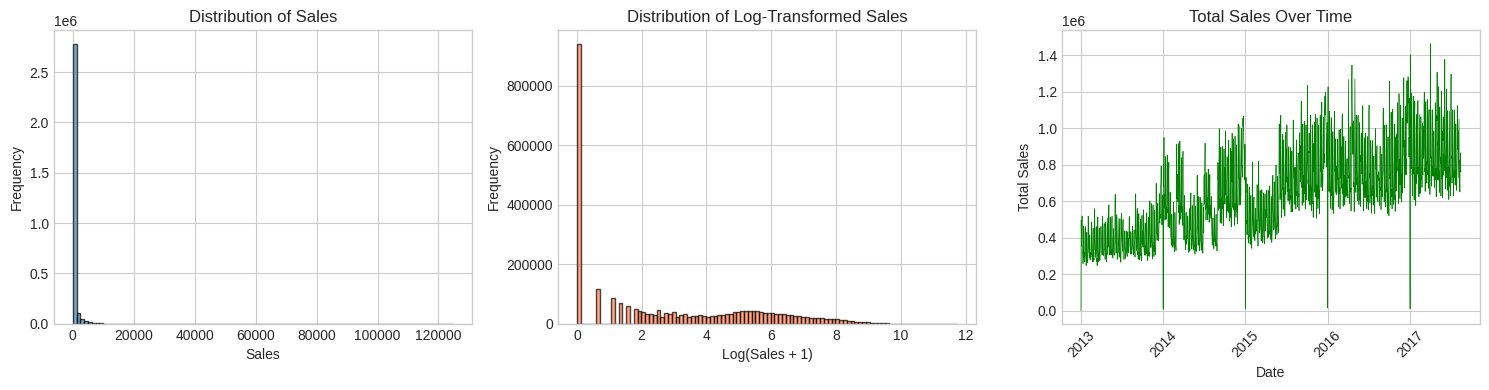


Statistical Summary of Target Class (sales):
count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

Key Observations regarding sales:
  - Sales range: 0.00 to 124717.00
  - Mean sales: 357.78
  - Median sales: 11.00
  - Zero sales records: 939,130 (31.30%)

Feature data type Analysis:

Train Dataset:
----------------------------------------
  id                   | int64           | Numerical (Continuous)         | Unique: 3000888
  date                 | datetime64[ns]  | Temporal (Date)                | Unique: 1684
  store_nbr            | int64           | Numerical (Continuous)         | Unique: 54
  family               | object          | Categorical (Nominal)          | Unique: 33
  sales                | float64         | Numerical (Continuous)         | Unique: 379610
  onpromotion          | int64           | Numerical (Contin

In [3]:
# 1. DATASET AND DESCRIPTIONS

print(f"Dataset Overview")
total_train_samples = len(train)
total_test_samples = len(test)
num_features = train.shape[1] - 1

print(f"Total number of samples in train dataset: {total_train_samples}")
print(f"Total number of samples in test dataset: {total_test_samples}")
print(f"Total number of samples: {total_train_samples + total_test_samples}")
print(f"Total number of features: {num_features} features + 1 target variable (sales)")

# supplementary datasets overview
print("\nSupplementary Datasets Overview")
print(f"Stores dataset shape: {stores.shape}")
print(f"Oil dataset shape: {oil.shape}")
print(f"Holidays dataset shape: {holidays.shape}")
print(f"Transactions dataset shape: {transactions.shape}")
print(f"Stores metadata: {len(stores)} stores with {stores.shape[1]} features")
print(f"Oil prices: {len(oil)} daily records")
print(f"Holidays: {len(holidays)} holidays")
print(f"Transactions: {len(transactions)} records")


# training data info
print("\nTrain Dataset Structure:")
print(train.info())
print("\nFirst 5 rows of training data:")
display(train.head())

# Data distribution of sales
print("\nData Distribution of target class Sales:")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution of sales
axes[0].hist(train['sales'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sales')


# Log-transformed distribution since we use RMSLE
train['log_sales'] = np.log1p(train['sales'])
axes[1].hist(train['log_sales'], bins=100, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Sales + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log-Transformed Sales')

# Sales over time (aggregated)
daily_sales = train.groupby('date')['sales'].sum().reset_index()
axes[2].plot(daily_sales['date'], daily_sales['sales'], color='green', linewidth=0.5)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Total Sales')
axes[2].set_title('Total Sales Over Time')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical summary of  sales
print("\nStatistical Summary of Target Class (sales):")
print(train['sales'].describe())

print(f"\nKey Observations regarding sales:")
print(f"  - Sales range: {train['sales'].min():.2f} to {train['sales'].max():.2f}")
print(f"  - Mean sales: {train['sales'].mean():.2f}")
print(f"  - Median sales: {train['sales'].median():.2f}")
print(f"  - Zero sales records: {(train['sales'] == 0).sum():,} ({(train['sales'] == 0).mean()*100:.2f}%)")

# Feature analysis
print("\nFeature data type Analysis:")
def analyze_feature_types(df, name):
    print(f"\n{name}:")
    print("-" * 40)
    for col in df.columns:
        dtype = df[col].dtype
        nunique = df[col].nunique()

        if dtype == 'datetime64[ns]':
            ftype = "Temporal (Date)"
        elif dtype in ['int64', 'float64']:
            if nunique < 20:
                ftype = "Categorical (Encoded as Numeric)"
            else:
                ftype = "Numerical (Continuous)"
        elif dtype == 'object':
            ftype = "Categorical (Nominal)"
        elif dtype == 'bool':
            ftype = "Boolean"
        else:
            ftype = "Other"

        print(f"  {col:20} | {str(dtype):15} | {ftype:30} | Unique: {nunique}")

analyze_feature_types(train, "Train Dataset")
analyze_feature_types(stores, "Stores Dataset")
analyze_feature_types(oil, "Oil Dataset")
analyze_feature_types(holidays, "Holidays Dataset")
analyze_feature_types(transactions, "Transactions Dataset")


### **Discussion:**

The implemented code performs a comprehensive initial examination of the **"Store Sales - Time Series Forecasting"** dataset. It utilizes the `Pandas` library for `data structure manipulation` and `Matplotlib` for `visualizing` distributions.

1.   The code first **quantifies** the **scale** of the dataset by calculating the shapes of the `train (3M+ rows)` and `test sets`, as well as the four `supplementary datasets (stores, oil, holidays, transactions)`.
2.   By plotting both the `raw distribution` and the `Log-transformed distribution (np.log1p)`, the code **visually** depicts the extreme skewness of retail sales data. The inclusion of a `time-series plot (daily_sales) aggregates` sales by date, providing an immediate `visual check` for seasonality and trends over the `4-year period`.
3. The `analyze_feature_types` function automates the classification of data type of features . It intelligently distinguishes between `categorical features (like family or city), temporal features (date), and numerical features` based on data types and unique value counts.

### **Analysis:**


1.  **Dataset used :** We utilized the **"Store Sales - Time Series Forecasting(Kaggle Competition)"** dataset contains historical sales data from Corporación Favorita provided by **Favorita**, a major grocery retailer in Ecuador. The dataset is a relational database consisting of a primary training file and several supplementary metadata files(stores, oil, holidays, transactions)..
    *   The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.
    * Link to the dataset: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

2. **Samples in the dataset:**
    * **Train Samples:** 3,000,888 records.
    * **Test Samples:** 28,512 records
    *  **Total Samples:** 3,029,400 rows of time-series data.

3. **Labeled vs. Unlabeled data:**
    * The dataset is **labeled**, making this a **Supervised Learning regression task**. It is partitioned into a **training set** containing **3,000,888 labeled samples** where the target 'sales' is provided and a **test set** containing **28,512 unlabeled samples** where 'sales' must be predicted.

4. **About the Data:**
      * **Type of the data:** This is a **multivariate time-series dataset**. It combines *structured tabular data* (store IDs, product families) with *temporal sequences* (daily records).
      * **Dataset contains:** The data represents retail sales volume for specific product families at specific stores in Ecuador from 2013 to 2017. goal is to predict unit sales for thousands of product families sold at different Favorita stores.


5. **Data Distribution of the target variable `sales`:**
      * The data is highly **right-skewed**. The **mean sales (357.78)** is drastically higher than the **median (11.00)**, indicating a "long tail" of high-volume sales events.
      * A **substantial portion** of the data `(31.30%)` consists of `zero sales`. This suggests that many product families do not sell every day at every store, or the store was closed.
      * **Sales range** from `0 to a maximum of 124,717 units` in a single day for a product family.

6. **Dataset Feature Analysis:**
      * **Categorical (Nominal):**
           * `family` : 33 unique product categories (e.g., AUTOMOTIVE, BEVERAGES, BOOKS, BABY CARE, etc.).
           * `city` : 22 unique cities(e.g., Quito, Guayaquil, Santo Domingo, etc.) where stores are located.
           * `state` : 16 unique states(e.g., Pichincha, Guayas, Cotopaxi, etc.) where stores are located.
           * `type` : 5 store types (A, B, C, D, E).
           * `locale` : Scope of a holiday (Local, Regional, National).
           *  `type (holidays)` : Holiday type (Holiday, Event, etc.).
           *  `locale_name` : Name of locale (Ecuador, Quito, etc.).
           *  `description`: Holiday description
      * **Categorical (Ordinal):**
           * `cluster` : 17 clusters grouping similar stores (likely ordinal based on store size/demographics).
      * **Numerical (Continuous):**
           * `sales` : Target variable
           * `onpromotion` : The count of items on promotion for a specific family/store/date.
           * `transactions`: Total transactions at a store per day.
           * `dcoilwtico` : Daily oil price.
      * **Temporal:**
           * `date` : Date of record, ranging from 2013-01-01 to 2017-08-15.

      * **Identifier:**
           *  **id:** Unique record identifier
           *  **store_nbr:** Store identifier


**NOTE:** As we are dealing TABULAR/TIME SERIES data. No images, audio, or text requiring special preprocessing (tokenization, MFCCs, etc.) are present in this dataset.

      


### **DATA PRE-PROCESSING**

Merged Dataset:
Shape after merging datasets: (3000888, 13)
Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'log_sales', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'transactions']
Missing Value Analysis and Handling

Missing Values Before Treatment:
              Missing Count  Percentage
dcoilwtico           928422       30.94
transactions         245784        8.19

Oil prices (dcoilwtico):
  Missing values before: 928422
  Missing values after (ffill + bfill): 0

Transactions:
  Missing values before: 245784
  Missing values after (group median imputation): 0

Missing Values After Handling:
0 total missing values

Handling Categorical Variables

Categorical columns to encode: ['family', 'city', 'state', 'type']

family: 33 unique values
  Sample: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS']

city: 22 unique values
  Sample: ['Quito' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra']

state: 16 unique values
  Sample: ['Pichincha' 'Cotopaxi' 'Chimbora

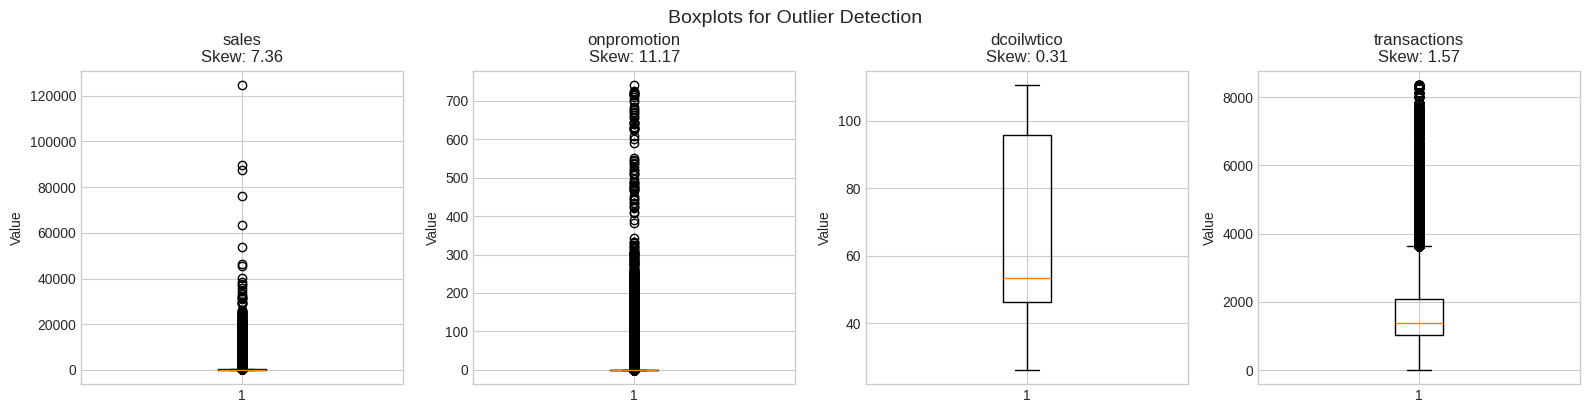


Outlier Analysis (IQR Method):
  sales: 447,105 outliers (14.90%)
  onpromotion: 611,329 outliers (20.37%)
  dcoilwtico: 0 outliers (0.00%)
  transactions: 150,117 outliers (5.00%)


In [9]:
# 2. DATA PRE-PROCESSING

print(f"Merged Dataset:")
# Merge train with stores
df = train.merge(stores, on='store_nbr', how='left')
# Merge with oil prices
df = df.merge(oil, on='date', how='left')
# Merge with transactions
df = df.merge(transactions, on=['date', 'store_nbr'], how='left')
print(f"Shape after merging datasets: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Missing value analysis
print("Missing Value Analysis and Handling")
# Check missing values
print("\nMissing Values Before Treatment:")
missing_before = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_before, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])
# Handle missing values
# Interpolate Oil Prices
print(f"\nOil prices (dcoilwtico):")
print(f"  Missing values before: {df['dcoilwtico'].isnull().sum()}")
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
print(f"  Missing values after (ffill + bfill): {df['dcoilwtico'].isnull().sum()}")

# Transactions: Fill with median for that store
print(f"\nTransactions:")
print(f"  Missing values before: {df['transactions'].isnull().sum()}")
df['transactions'] = df.groupby('store_nbr')['transactions'].transform(
    lambda x: x.fillna(x.median())
)
# If still missing (new stores), fill with overall median
df['transactions'] = df['transactions'].fillna(df['transactions'].median())
print(f"  Missing values after (group median imputation): {df['transactions'].isnull().sum()}")

# Verification
print("\nMissing Values After Handling:")
print(df.isnull().sum().sum(), "total missing values")

# Handle Categorical variables
print("\nHandling Categorical Variables")
categorical_cols = ['family', 'city', 'state', 'type']
print(f"\nCategorical columns to encode: {categorical_cols}")
categorical_summary = {}
for col in categorical_cols:
    categorical_summary[col] = {
        'unique_values': df[col].nunique(),
        'sample_values': df[col].unique()[:5].tolist()
    }
    print(f"\n{col}: {df[col].nunique()} unique values")
    print(f"  Sample: {df[col].unique()[:5]}")
# Apply Label Encoding
print("\nApplying Label Encoding:")
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"  {col} -> {col}_encoded (0 to {df[col + '_encoded'].max()})")

# encoding mapping for 'type' (store type)
print("\nStore Type Encoding Mapping:")
for i, label in enumerate(label_encoders['type'].classes_):
    print(f"  {label} -> {i}")

# Extract temporal features from date
print("Extracting Temporal Features from Date")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

# Payday indicator: 15th and last day of the month
df['is_payday'] = ((df['day'] == 15) | (df['is_month_end'] == 1)).astype(int)

# Earthquake impact: April 16, 2016 - several weeks
earthquake_date = pd.Timestamp('2016-04-16')
df['days_since_earthquake'] = (df['date'] - earthquake_date).dt.days
df['earthquake_impact'] = ((df['days_since_earthquake'] >= 0) &
                           (df['days_since_earthquake'] <= 60)).astype(int)

print("Temporal features created:")
temporal_features = ['year', 'month', 'day', 'day_of_week', 'day_of_year',
                     'week_of_year', 'is_weekend', 'is_month_start',
                     'is_month_end', 'is_payday', 'earthquake_impact']
for feat in temporal_features:
    print(f"  - {feat}: {df[feat].nunique()} unique values")

print(f"\nDataset shape after feature extraction: {df.shape}")

# Normalization/Standardization
print("Normalization/Standardization of Numerical Features")
numerical_features = ['onpromotion', 'dcoilwtico', 'transactions', 'cluster']

print("Numerical features to standardize:")
for feat in numerical_features:
    print(f"  - {feat}: range [{df[feat].min():.2f}, {df[feat].max():.2f}]")

# Apply StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()

for feat in numerical_features:
    df_scaled[feat + '_scaled'] = scaler.fit_transform(df[[feat]])
    print(f"\n{feat}_scaled: mean={df_scaled[feat + '_scaled'].mean():.4f}, std={df_scaled[feat + '_scaled'].std():.4f}")


# Outlier & Skewness Detection
print("Outliers detection and Skewness Analysis")

# Analyze skewness
print("\nSkewness Analysis:")
skew_cols = ['sales', 'onpromotion', 'dcoilwtico', 'transactions']
for col in skew_cols:
    skewness = df[col].skew()
    print(f"  {col}: skewness = {skewness:.3f} {'(highly skewed)' if abs(skewness) > 1 else '(moderate)' if abs(skewness) > 0.5 else '(normal)'}")

# Visualize outliers with boxplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, col in enumerate(skew_cols):
    axes[i].boxplot(df[col].dropna(), vert=True)
    axes[i].set_title(f'{col}\nSkew: {df[col].skew():.2f}')
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.suptitle('Boxplots for Outlier Detection', y=1.02, fontsize=14)
plt.show()

# Outlier detection using IQR
print("\nOutlier Analysis (IQR Method):")
for col in skew_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"  {col}: {outliers:,} outliers ({outliers/len(df)*100:.2f}%)")

### **Discussion:**

* The **Data Pre-processing pipeline** was implemented to transform the **raw relational tables** into a clean **single machine learning ready dataset**.

* The process began by **merging** the `primary train dataset` with `supplementary datasets (stores, oil, transactions)` using `left joins` to preserve the integrity of the training timeline.

* We employed domain-specific **imputation strategies**: `forward/backward filling` for the **continuous oil time-series** and `median imputation` for **store transactions** .

* Following cleaning, we generated **extensive temporal features**, parsing the date column to create granular inputs like `day_of_week`, `is_weekend`, and domain-specific boolean flags for Ecuadorian paydays (`is_payday`) and the 2016 earthquake (`earthquake_impact`).

* We applied `LabelEncoder` to encode **categorical variables** to convert strings into numerical formats suitable for regression models.

* we utilized `StandardScaler` to **normalize continuous features**, ensuring that variables with large ranges (like transaction counts) do not dominate variables with smaller ranges (like oil prices).

* And, then Visualised **outliers** using `box plots` and detected outliers using `IQR Method`.

### **Analysis:**

1. We applied a **comprehensive set of techniques**:
      * **Data Integration:** Merging four distinct CSV files (train, stores, oil, transactions) into a unified dataframe.
      * **Imputation:** Filling missing values in oil prices(Forward\Backward fill) and transaction counts(group median imputation).
      * **Encoding:** Converting string-based categorical data into integers. Extracting 11 new features from the timestamp (e.g., is_payday, earthquake_impact).
      * **Scaling:** Standardizing numerical features to a common scale.
 2. We identified **significant missing data** in dcoilwtico (30.94%) and transactions (8.19%). We **avoided deletion** to preserve the time-series continuity. And handled the missing values using the following methods:
      * **Oil Prices:** We used `Interpolation (Forward-fill followed by Backward-fill)`. Since oil prices change gradually, the price from the previous day is the most accurate predictor for a missing day.

      * **Transactions:** We used `Grouped Median Imputation`. We calculated the median transaction count per store to fill gaps. The median was chosen over the mean because transaction data is highly skewed, and the mean would be distorted by outliers.

3. We utilised **Label Encoding** for the variables `family, city, state, and type`.
      * **Rationale:** The `family` feature has high cardinality 33 unique product types. Using One-Hot Encoding would have added 33 new columns plus more for cities and states, significantly increasing dimensionality and memory usage. Label encoding keeps the dataset compact

4. Yes, we applied **Standardization using StandardScaler** to `onpromotion`, `dcoilwtico`, `transactions`, and `cluster`.
       
     * **Rationale:** The raw data had vastly different scales. `onpromotion` ranged from `0 to 741`, while `cluster` ranged from `1 to 17`. Without scaling, algorithms especially those relying on distance or gradient descent might bias the model toward features with larger raw numbers. Scaled data to have a mean of 0 and a standard deviation of 1

5. **Detection:** We used the `Interquartile Range (IQR)` method and `Skewness coefficient`. The analysis revealed that `sales (skew: 7.36)` and `onpromotion(skew: 11.17)` are **highly right-skewed**. The IQR method flagged `14.9% of sales` records, `20.37% of onpromotion` and `5.00% of transactions` as outliers.

   **Handling:** We chose **not to remove these outliers**. In retail forecasting, "outliers" often represent the real business events & most critical sales days (e.g., Christmas, Black Friday). `Removing outliers` could `bias the model against high-sales` periods Instead, we rely on the **Log-transformation** of the target variable.

6. As this is a **Regression problem** predicting a *continuous quantity(sales)* rather than a Classification problem, `class balancing` techniques like SMOTE are `not applicable`. However, we did note a `"zero-inflation" issue` (31% of sales are 0). We addressed this by engineering features like onpromotion and `is_holiday` to help the model distinguish between days with zero demand versus active sales days.

7. In this specific pre-processing pipeline, we **did not apply dimensionality reduction** techniques like PCA or LDA.
      * **Rationale:** Feature count which is 29 is manageable for tree-based models.  PCA destroys interpretability of features.  We will use feature importance from models instead.